# **Title: Detecting Paediatric Pneumonia by classification of Linearized Chest X-Ray Images**
---

## **Introduction**

  Pneumonia is a lung disease caused by bacterial infection in the lungs. The infection causes our air sacs (where oxygen enters into the blood) to fill up with fluid or pus, hence disturbing the process of diffusing oxygen into the blood and making it hard for one to breathe. Pneumonia is the main cause of death for people under the age of 5, with over 800,000 child fatalities due to the disease in 2017 alone. Similarly to cancer, one of the most crucial ways to detect early stages of pneumonia is through chest x-ray images. Through an x-ray scan, a doctor is able to identify inflammation in the lungs and thus able to perform the necessary treatments early. However, inaccurate analysis of the x-ray results may result in an improper diagnosis and decision making, resulting in a costly mistake that could otherwise save lives.      

  The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability. Here, we establish a diagnostic tool based on a classification framework for the screening of patients’ x-ray to quickly and accurately **identify paedeatric pneumonia from linearized chest x-rays images**.
 
  We have obtained a database of images of chest x-rays from Kaggle (<https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>).
    The dataset provided by Kaggle contains about 6000 grey-scaled images, consisting of  `training`, `validating`  and  `testing` sets. Due to the huge amount of data to wrangle (more than 1GB), we are only extracting images from the `training` database, totalling `5216`  labelled images,  to create our own set of training and testing data set that will be used to train our model. There are 3875 `PNEUMONIA` class images and 1341 images of class `NORMAL` specifically.

## **Methodology**

Inside the training set folder provided, the images are split into Normal and Pneumonia images. Our plan is to split the image into smaller pixels and then calculate the shade of the picture in that specific pixel size. The "darkness" of the pixel will then be given a range from 0-1. We will then linearize the data. For example, if we split the image into 10 rows and 20 columns, we will have values of the shade of the picture in 10 rows and 20 columns, but then we’ll linearize the data to make it into a single column with 200 columns. So, we will do this to all the images in the Normal and Pneumonia folders respectively. 

Then, we will add a column that we will use as the categorical variable . Doing so will allow us to separate and differentiate the images that are from the normal group and the ones that are from the pneumonia group. The nomenclature that we have chosen is that the images that are from the normal group are to have the “category: 0” and the images that are from the pneumonia group are to have the “category: 1”. 

Then, we’ll split the data into training and testing data set and then scale the data. Afterwards, we’ll do knn-classification on various values of K using train control, plot the “accuracy vs K” graph from the models to choose the optimal value of K. Finally, we’ll create the final model for the optimal value of K and access its accuracy by using the model to predict values in the test dataset and compare it to the actual categorical variables given before in the test dataframe.

[](http://)
## **1 Data Wrangling**

### 1.1 Importing Libraries 

First of all, we need to decide the libraries that we will be using. We used functions from the  `tidyverse` library to manipulate data frames and tibbles. `repr` is used to resize plots contained in this notebook, such as an  “Accuracy vs K”  graph. The `caret` library is used to access the train functions to create our classification model. The dbplyr package will also be used to rename the columns should it be required and last but not the least, `imager` allow us to linearize the images into a data frame/tibble as well as to display the images.



In [36]:
# import libraries
library(tidyverse)
library(imager)
library(repr)
library(caret)
library(dbplyr)

The set of images has already been loaded into the this server. We can start by setting up a list of references to the pictures of the class `Normal`, and then plotting a sample picture.

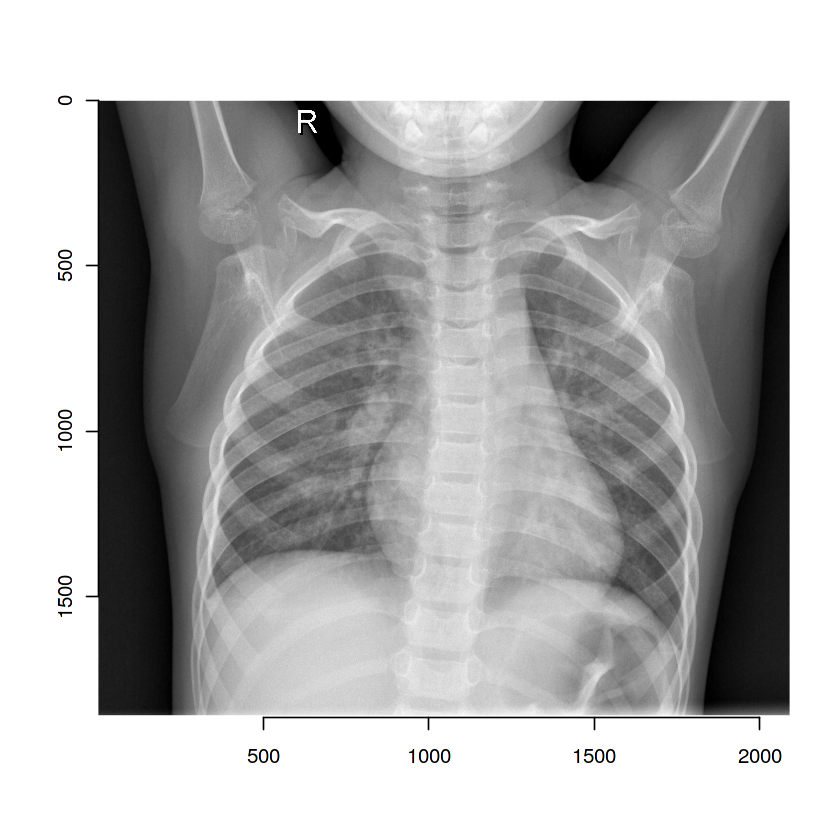

In [37]:
# set up list of paths to pictures in the 
train_NORMAL_dir <- '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/'
train_NORMAL <- list.files(train_NORMAL_dir)

# plot sample image
test_image <- load.image(paste(train_NORMAL_dir, train_NORMAL[1], sep=''))
plot(test_image)

<div align="center"> Figure 1: Original class 'Normal' X-ray scan </div>

### 1.2 Resizing images
We proceeded to resize all images from an orignal size of (2090 x 1858) pixels to (20 x 20) pixels. This allows us to significantly reduce computational time in the classification stage because there will be a smaller amount of columns to process.

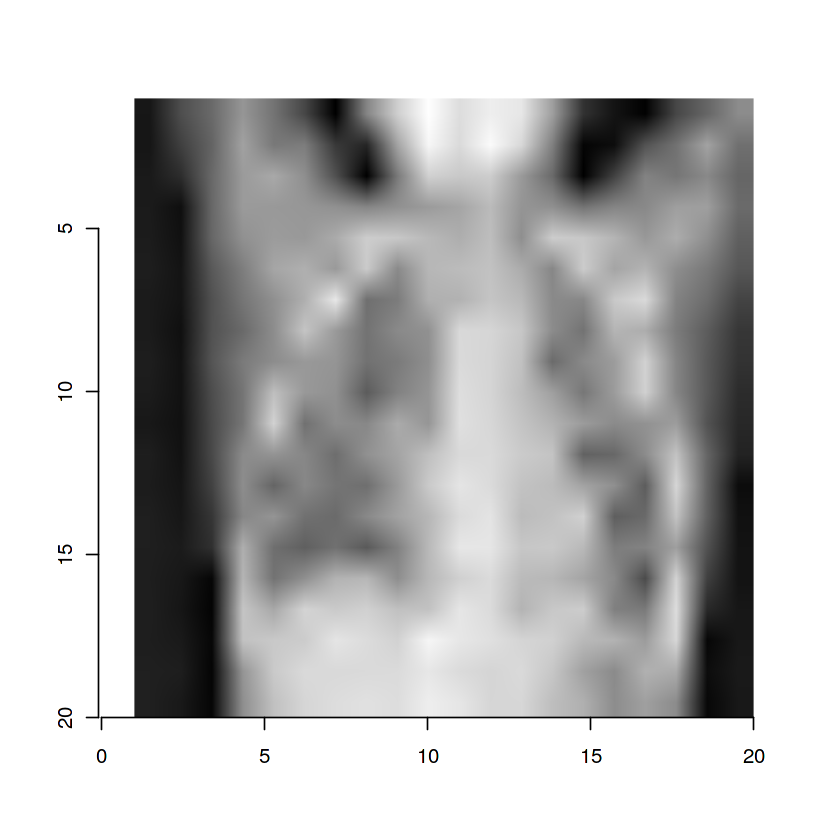

In [38]:
# resizing `normal` image
new_height <- 20
new_width <- 20
resized_test_image <- resize(test_image, new_width, new_height)
plot(resized_test_image)

<div align="center"> Figure 2: Resized class 'Normal' X-ray scan </div>

### 1.3 Creating data frame

Next, we initialize a data frame and fit every picture from the class `normal` into a row in the data frame.
This process is called **linearizing data**. The image is a matrix of 20 by 20 pixels and after linearization it transforms into a single column vector with 400 rows. 

In [39]:
# create empty data frame of images from class 'normal'
df_NORMAL <- data.frame(matrix(NA, nrow = length(train_NORMAL), ncol = new_height * new_width)) 

The most important (and lengthy) part of the process of data wrangling is going to be fitting every picture within the working directory into the dataframe we have just created. Basically, for every row of the dataframe we assign a linearized picture from the `normal` class. The first line of the loop imports the image into the environment, the second applies the same resizing parameters we used earlier, and the third turns the thumbnail picture into a row vector. Here we also measure the time it takes to perform this process.

In [40]:
#linearize data
start.time <- Sys.time() # start
for (i in 1:length(train_NORMAL)) {
    im <- load.image(paste(train_NORMAL_dir, train_NORMAL[i], sep=''))
    thmb <- resize(im, new_height, new_width)
    df_NORMAL[i,] <- t(as.vector(thmb))
}
end.time <- Sys.time() # stop
print(end.time - start.time)

Time difference of 2.795441 mins


We then add a categorical variable, `y`, as an additional column in our data frame to differentiate between the `pneumonia` and `normal` class.  We set the `normal` class to hold a numerical value of `0`. 

In [41]:
# set y = 0 (class = normal)
y <- 0
df_NORMAL <- cbind(df_NORMAL, y)
head(df_NORMAL)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X392,X393,X394,X395,X396,X397,X398,X399,X400,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.08627451,0.29019608,0.3960784,0.55686275,0.4313725,0.2627451,0.0000000,0.4941176,0.7686275,0.9490196,⋯,0.7960784,0.8000000,0.7058824,0.6549020,0.5254902,0.5960784,0.5215686,0.03137255,0.09019608,0
2,0.04313725,0.18431373,0.3568627,0.36862745,0.5803922,0.5098039,0.7843137,0.8156863,0.7294118,0.7607843,⋯,0.9764706,0.4627451,0.4549020,0.5333333,0.4431373,0.3764706,0.4980392,0.41568627,0.00000000,0
3,0.00000000,0.21960784,0.3372549,0.45098039,0.2862745,0.5921569,0.6196078,0.7686275,0.9960784,0.6784314,⋯,0.8117647,0.8000000,0.7921569,0.7098039,0.7411765,0.7686275,0.6470588,0.44313725,0.00000000,0
4,0.14117647,0.32549020,0.4039216,0.59215686,0.5607843,0.4509804,0.5019608,0.6705882,0.7725490,0.8745098,⋯,0.7764706,0.7686275,0.7882353,0.8313725,0.7647059,0.7215686,0.6823529,0.40784314,0.00000000,0
5,0.29411765,0.09019608,0.1254902,0.07843137,0.0000000,0.0000000,0.0000000,0.2745098,0.7019608,0.7490196,⋯,0.8627451,0.7843137,0.7725490,0.6745098,0.7607843,0.6352941,0.5490196,0.44313725,0.00000000,0
6,0.56078431,0.65490196,0.8000000,0.71764706,0.6392157,0.6509804,0.5647059,0.6313725,0.6509804,0.6392157,⋯,0.8156863,0.7411765,0.7647059,0.8392157,0.7529412,0.7450980,0.6784314,0.64313725,0.17647059,0


At this point, we have completed linearizing the images of class `normal`. Now, we need to linearize the images of class `pneumonia`. It is pre-processed similarly with the only difference being the `pneumonia` class will have a label of 1 instead of 0. This is done by setting `y` as 1 instead of 0.

In [42]:
# load images from Kaggle
train_PNEUMONIA_dir <- '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/'
train_PNEUMONIA <- list.files(train_PNEUMONIA_dir)

# load sample image
test_image <- load.image(paste(train_PNEUMONIA_dir, train_PNEUMONIA[1], sep=''))

#r esize image
resized_test_image <- resize(test_image, new_width, new_height)

#create data frame for pneumonia images
df_PNEUMONIA <- data.frame(matrix(NA, nrow = length(train_PNEUMONIA), ncol = new_height * new_width))

#linearize data
start.time <- Sys.time() # start
for (i in 1:length(train_PNEUMONIA)) {
    im <- load.image(paste(train_PNEUMONIA_dir, train_PNEUMONIA[i], sep=''))
    thmb <- resize(im, new_width, new_height)
    df_PNEUMONIA[i,] <- t(as.vector(thmb))
}
end.time <- Sys.time() # stop
print(end.time - start.time) # display time interval

# set y = 1 (class = pneumonia)
y <- 1
df_PNEUMONIA <- cbind(df_PNEUMONIA, y)
head(df_PNEUMONIA)

Time difference of 3.290735 mins


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X392,X393,X394,X395,X396,X397,X398,X399,X400,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.27058824,0.32156863,0.36078431,0.513725490,0.5254902,0.6745098,0.4980392,0.4666667,0.6039216,0.6196078,⋯,0.7568627,0.7019608,0.6941176,0.7372549,0.7058824,0.7254902,0.6941176,0.54509804,0.22745098,1
2,0.05882353,0.15686275,0.27843137,0.282352941,0.2549020,0.2196078,0.2666667,0.3294118,0.3686275,0.5372549,⋯,0.7529412,0.7803922,0.7176471,0.7098039,0.6941176,0.7372549,0.7411765,0.68235294,0.22745098,1
3,0.00000000,0.03921569,0.02745098,0.003921569,0.1294118,0.2156863,0.2745098,0.2980392,0.4117647,0.3137255,⋯,0.6274510,0.6039216,0.6431373,0.6666667,0.6705882,0.5764706,0.4431373,0.25882353,0.00000000,1
4,0.25490196,0.23921569,0.24705882,0.235294118,0.2000000,0.2980392,0.1803922,0.2862745,0.2705882,0.3058824,⋯,0.6392157,0.5725490,0.6156863,0.6313725,0.5411765,0.4705882,0.5019608,0.51372549,0.18039216,1
5,0.07450980,0.20000000,0.23137255,0.231372549,0.2784314,0.3764706,0.4941176,0.4392157,0.4156863,0.4588235,⋯,0.7372549,0.7058824,0.7137255,0.7411765,0.7019608,0.6941176,0.3803922,0.09803922,0.05098039,1
6,0.25882353,0.38823529,0.38823529,0.384313725,0.4941176,0.5058824,0.6431373,0.6627451,0.6862745,0.7176471,⋯,0.7607843,0.7176471,0.6823529,0.6509804,0.6392157,0.6000000,0.6392157,0.55294118,0.06666667,1


Let's see what positive results for pneumonia look like as we did for the normal results.

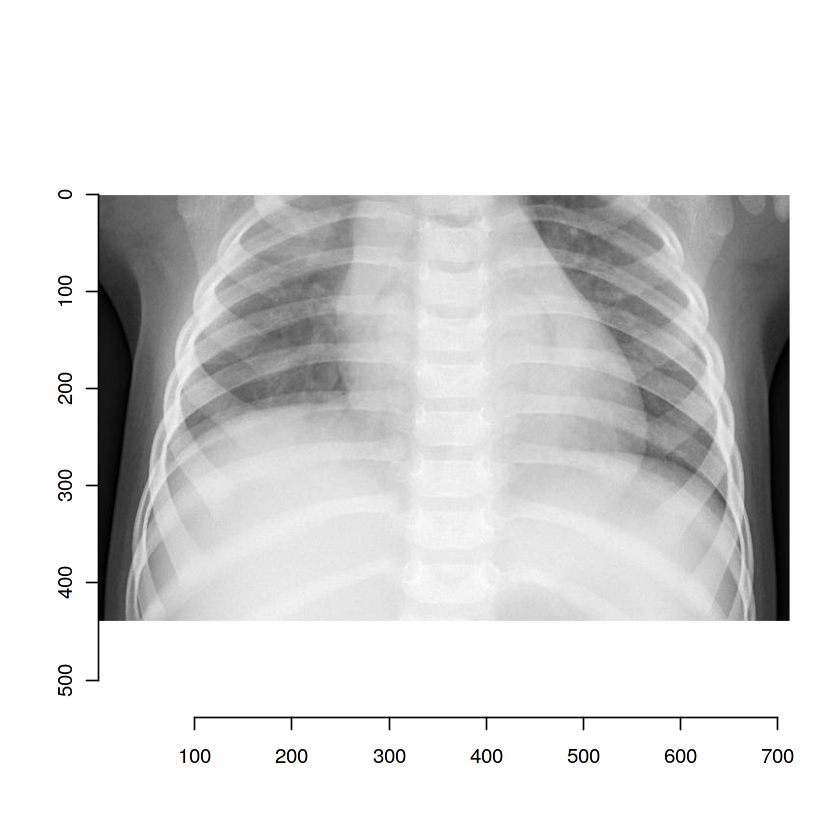

In [43]:
plot(test_image)

<div align="center"> Figure 3: Original class 'Pneumonia' X-ray scan </div>

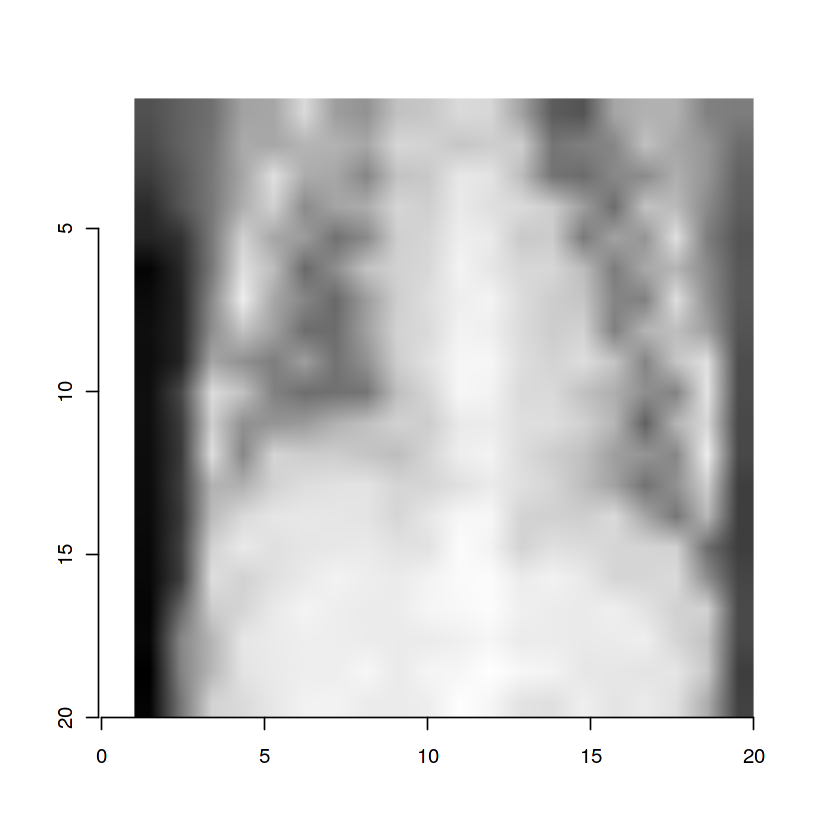

In [44]:
plot(resized_test_image)

<div align="center"> Figure 4: Resized class 'Pneumonia' X-ray scan </div>

### 1.4 Combining Data Frames

So far, we have succeeded in linearizing the normal and pneumonia group images into their respective data frames: `df_NORMAL` and `df_PNEUMONIA`. Since they both underwent the same linearization process, they have the same number of columns (ncols=400) but different number of rows because there are more images for Pneumonia (nrows=3875) than the images for Normal (nrows=1346). We would need to fix this later on.
 
To combine our datasets, we used `rbind` which combines the rows from the normal dataset with the rows from the pneumonia dataset. This process is similar to stacking datasets together.

In [45]:
# combine dataset using rbind 
dataset <- rbind(df_NORMAL, df_PNEUMONIA) %>%
    mutate(y = as.factor(y))

### 2 Splitting, scaling and balancing the dataset
### 2.1 Splitting into training and testing sets

As of now, we have a single giant data frame consisting of all the linearized images. If we pass all of the images into our classifier, we would not have any images to use as a measure of how accurate the model is. If we use the data that we have used to train the model before, the model will recognize that image because it has “seen” it before and will most likely predict correctly.
 
Therefore, to allow a fair process of measuring the model’s accuracy, we must calculate its accuracy based on how accurate it is at predicting images that it hasn’t “seen” before. To do this, we can split the data into `training` and `testing` datasets and only use the training dataset to create our classification model. By doing so, we will have a set of images that the model hasn’t seen before which is the testing dataset. We can then use the testing dataset to estimate how accurate our model is at predicting “new” data.
 
To do this, we will use the golden ratio which is a 75-25% ratio of training and testing datasets respectively. We will use the function `createDataPartition()` to split our dataset by obtaining the rows that are considered training. By using this function we are also making sure input data is shuffled and stratified. We will name the resulting rows `training_rows`. 

To make sure that this process is replicable, we use `set.seed()`.

In [46]:
# make results reproducible
set.seed(2020)

training_data <- dataset %>%
    select(y) %>%
    unlist() %>%
    createDataPartition(p = 0.75, list = FALSE)

### 2.2 Balancing the dataset

Balancing data also affects our classification model if one data is heavily over dominated as compared to the other categories. For example, one category only has 1 data point and another has 50 data points. Hence, if we choose a k value of 3, no matter what point, the one category data point will always be outnumbered and hence, no data passed to the model will ever be classified in the outnumbered category. This means that the model is unbalanced.
 
In our case, there are 3875 images of class `pneumonia` and 1341 images of class `normal`. Hence, balancing our data will allow us to develop a more robust model. We will be upsampling the data which means for the normal class, the number of observations will be duplicated so that the number of observation of the normal class equals the number of observation of the pneumonia class.

In [47]:
unbalanced_train <- dataset %>% slice(training_data)
balanced_train <- upSample(x= unbalanced_train[, -ncol(unbalanced_train)], y= unbalanced_train$y)
colnames(balanced_train) <- balanced_train %>% rename("y" = Class) %>% colnames()

unbalanced_train_groups <- unbalanced_train %>% group_by(y) %>% summarise(n=n())

balanced_train_groups <- balanced_train %>% group_by(y) %>% summarise(n=n())

unbalanced_train_groups
balanced_train_groups

y,n
<fct>,<int>
0,1006
1,2907


y,n
<fct>,<int>
0,2907
1,2907


As we can see from the two tables printed out, the first table represents the number of observations for each class before it was balanced. Previously, the normal class had 1006 observations whereas the pneumonia had 2907. After balancing, they have the same number of classes as shown in the second table. 

Notice how the balancing is only done to the training set and not to the testing set. This is because the balancing is only important for the model, but whilst testing the model, we don't necessarily need to test and equal amount of classes, hence, we are only balancing the training set.

Now that our data is balanced, we are ready to split it into feature data frames and label vectors. We use `slice(training_rows)` to get the training data set and use `slice(-training_rows)` to get the testing data set.

In [48]:
# split data into training and testing sets
X_train <- balanced_train %>%
    select(-y) %>%
    slice(training_data) %>%
    data.frame()
Y_train <- balanced_train %>%
    select(y) %>%
    slice(training_data) %>%
    unlist()
X_test <- dataset %>%
    select(-y) %>%
    slice(-training_data) %>%
    data.frame()
Y_test <- dataset %>%
    select(y) %>%
    slice(-training_data) %>%
    unlist()


### 2.3 Shifting and scaling the dataset

Shifting and scaling data are important steps in the process of building classification models, but since every observation in this dataset is on the same scale (400 pixel values between 0 and 1), there is no need for such transformations as they will have a very small impact on the results.

### 3 Knn classification
### 3.1	Using trainControl to assess the accuracy of the model with different values of k

Firstly, we’ll need to make a data frame for the range of values of k that we would like to try to determine the optimum k for our model. We have decided on the range of k from 1 to 21. We will be using `seq()` function to create our dataframe.

In [49]:
set.seed(2020)
k <- data.frame(k = seq(from = 1, to = 21, by = 1))

We used `trainControl` to assess the accuracy of the model with different values of k. Our train control will be using a 5-fold cross validation in order to obtain better results. The method `cv` corresponds to cross validation. 

In [50]:
set.seed(2020)
train_control <- trainControl(method = "cv", number = 5)

We will then pass all of these arguments into the `train()` function to create our model. The `method = “knn”` corresponds to the fact that we are doing knn classification. After we create our model, we can then extract the accuracy column of our model to see how accurate our model was for different values of k.

In [51]:
set.seed(2020)
selecting_k <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
k_accuracies <- selecting_k$results %>% select(k, Accuracy)

### 3.2 Visualize the models through "Accuracy vs K' plot 

We constructed an “Accuracy vs K” plot to decide which value of k will be the optimal for our model. We chose the highest point in the graph as the optimum value of K as the highest point means it has the highest accuracy. We will be using `ggplot()` to create out plot. We will be creating a line and point plot because the line will help us determine the highest point more easily and the points will help us determine the corresponding value of K for that peak point. The arguments for ggplot will be `geom_point()` for the scatter plot, and `geom_line()` for the line plot.

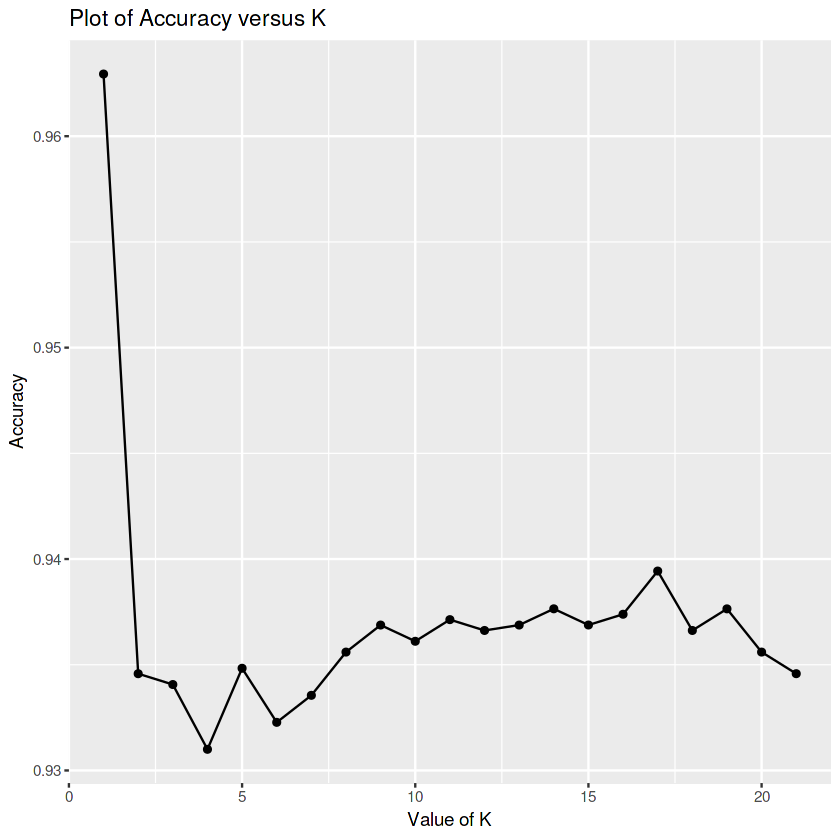

In [52]:
set.seed(2020)
accuracy_k_plot <- k_accuracies %>% 
    ggplot(aes(x = k,y = Accuracy)) +
        geom_point() + 
        geom_line() +
        labs(x = "Value of K", y = "Accuracy") +
        ggtitle('Plot of Accuracy versus K')
accuracy_k_plot

<div align="center"> Figure 5: Plot of Accuracy versus K </div>

The spike in the plot seems unreasonable, because it turns out that the upsampling added noise to the cross validation process. Therefore, k=1 is a false global optimum, since the evaluation of the model involved repeated images due to upsampling. Using this value of k would result in overfitting. We rather use the second highest point on the plot: k=17.

### 3.3	Training the final classification model and assessing its accuracy
To create our final classification model, we will need to make another dataframe consisiting of only the chosen value of k.

In [53]:
set.seed(2020)
chosen_k <- data.frame(k = 17)

We need to use the `train()` function again to create our classification model. This time, we don’t need to have the `trainControl` argument inside the train function because we have already selected a single value of k as our optimum value.
 

In [54]:
set.seed(2020)
knn_model <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = chosen_k)

Finally, we will pass the testing dataset into our final classification model. The model will predict the categories they should belong using the `predict()` function and using the `confusionMatrix()` function, we will compare its predictions with the actual labels.

In [55]:
# final classification  model
set.seed(2020)
Y_predicted <- predict(knn_model, X_test)
results <- confusionMatrix(data = Y_predicted, reference = Y_test)
results

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 316  91
         1  19 877
                                          
               Accuracy : 0.9156          
                 95% CI : (0.8991, 0.9301)
    No Information Rate : 0.7429          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7935          
                                          
 Mcnemar's Test P-Value : 1.292e-11       
                                          
            Sensitivity : 0.9433          
            Specificity : 0.9060          
         Pos Pred Value : 0.7764          
         Neg Pred Value : 0.9788          
             Prevalence : 0.2571          
         Detection Rate : 0.2425          
   Detection Prevalence : 0.3124          
      Balanced Accuracy : 0.9246          
                                          
       'Positive' Class : 0               
                              

Based on the confusion matrix above, the accuracy of our model obtained is 91.56%. From this accuracy and the values of sensitivity and specificity we can infer that our model is quite robust. In fact, the value for sensitivity tells us that it is classifying almost 19 out of 20 sick people correctly. In contrast, the value of specificity indicates that 1 out of 10 normal patients is being misclassified as having the disease.

### **4 Analysis**

#### 4.1 Correct and wrong predictions

To analyze the results of our model further, we want to see how many of the data in the testing dataset was predicted correctly by the model and how many were predicted wrong. We then want to see out of the ones that are predicted correctly, how many of them came from the one category and how many of them came from the other category. Similarly, we will do this for the ones predicted wrong. We will then be able to detect any possible imbalances.


In [94]:
set.seed(2020)
labels <- Y_test %>% data.frame()
predictions <- Y_predicted %>% data.frame()

# data frame of correc 
correct <- which(predictions == labels) %>% data.frame()
correct_count <- correct %>% summarise(n = n())

#list of wrongly labelled images
wrong <- which(predictions != labels) %>% data.frame()
wrong_count <- wrong %>% summarise(n = n())

correct_count
wrong_count

colnames(labels) = c("y")
colnames(correct) = c("category")
correct_category <- correct %>% mutate(category = labels$y[category])
correct_category %>% group_by(category) %>% summarise(n = n())

colnames(wrong) = c("category")
wrong_category <- wrong %>% mutate(category = labels$y[category])
wrong_category %>% group_by(category) %>% summarise(n = n())

n
<int>
1193


n
<int>
110


category,n
<fct>,<int>
0,316
1,877


category,n
<fct>,<int>
0,19
1,91


Hurray! We have completed the classification of our testing set, with a total of 1193 images predicted with the correct class labels, and 110 images predicted wrongly, achieving an accuracy of about 92.48%. Out of the ones that are predicted correctly, about 316 are from the normal category and 877 from the pneumonia category. If we just see the numbers, we would instantly assume that there is an imbalance in the data that it always predicts correctly for the Pneumonia Class. However, we need to remember about our data imbalance where the normal group is outnumber by a ratio of 1:3. We balanced the **TRAINING** dataset to have equal number of each class for training purposes but we never balanced the **TESTING** dataset which is why we have 3 times more pneumonia classes that we are testing and hence explains why there are more pneumonia categories predicted correctly.

This is supported by the portion of those predicted wrongly; about 19 are from the normal category and 91 are from the pneumonia category. Despite the ratio not being 1:3, the fact that there are more pneumonia predicted wrongly tells us that this is because of the imbalance of classes in the TESTING dataset.

We also would like to know what was the factor behind the images that were predicted correctly and the images that were wrongly predicted. We can't do a scatter plot comparison because we have a lot of variables and a multidimensional scatterplot would be very hard to interpret. Hence, because we are working with images, the best way to do this would be to print out the images that were predicted correctly and the ones predicted wrongly and then compare them directly. To do this, we need to see which image was predicted wrong. We can easily do this by doing:

In [57]:
# list of wrongly predicted images
head(wrong)

,.
,<int>
1,28
2,44
3,48
4,88
5,108
6,111


The numbers represent the row of the image that was predicted incorrectly. As an example, we will analyze the 28th image from our list of wrongly predicted images. One thing to note is that to create our database, we used the transpose function, t(). Our original images were actually from the type cimg, then converted into a matrix. We were unable to un-transpose our function, hence we were stuck with a matrix whose image we couldn't print.

To overcome this, what we decided is that we will slice the data from X_test, the index of X_test will not be the actual index of our big dataset because we already partitioned the big dataset as training and testing datasets. For example, if the picture was initially in row 400 (at the big dataset), it will no longer be in row 400 in X_test because some of the observations before it must've been partitioned to the training dataset. In X_test, the image would probably be in a row less than 400.

Hence, the step above involving head(wrong) was only to know the index of the image AT X_test. Now, we need to know the index of the image AT df_NORMAL which we will then use to print the image. We can do this by searching the exact row in df_NORMAL which has the exact same data values as the one in X_test.

In [95]:
look.for <- bind_cols(X_test) %>% slice(28)
look.for

Y_test %>% data.frame() %>% slice(28)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6431373,0.7607843,0.6117647,0.5764706,0.3803922,0.03921569,0.3921569,0.5529412,0.745098,0.6823529,⋯,0.8156863,0.8509804,0.6470588,0.654902,0.654902,0.654902,0.6470588,0.5607843,0.2078431,0.04313725


.
<fct>
0


The last column which determines the class label has a value of 0. Therefore it is under class `Normal`. The model has made an error and  incorrectly predicted the image `pneumonia`.

We can further analyze this example with an actual x-ray image which has class `pneumonia`.

To do the matching process, we need to import another library called prodlim which will allow us to compare cells between two tables. It will return to us the row number where all of the contents of that row are the same in both tables.

In [98]:
library(prodlim)
row.match(look.for, df_NORMAL%>% select(-y), nomatch = 0)

[1] 149

This number 29 means that the actual picture was in number 29 inside df_NORMAL. We can now use this index number to extract the picture from the collection of images.

In [99]:
# obtain image of class PNEUMONIA
compare_wrong_image <- load.image(paste(train_NORMAL_dir, train_NORMAL[149], sep=''))


Now lets get an image of an X-ray correctly predicted as pneumonia as well as one correctly predicted as normal to make a comparision. We will repeat the same process as before but this time, we will use the list of rows that the model predicted correctly.

In [101]:
# correctly classified x-ray images
head(correct)
correct

,category
,<int>
1,1
2,2
3,3
4,4
5,5
6,6


category
<int>
1
2
3
4
5
6
7
8
9


The first image in our list was correctly predicted as of class NORMAL, so we will be using that as a "benchmark" picture to compare a heart thats normal. Unforutanely, all the values in the first 6 slices were of classNORMAL. Therefore the entire list had to be printed out to obtain a "benchmark" picture with the PNEUMONIA class. We found that slice 1273 has been correctly predicted as PNEUMONIA, hence we will be working with that picture.

In [114]:
look.for_2 <- X_test %>% slice(1)
look.for_2

Y_test %>% data.frame() %>% slice(1)


look.for_3 <- X_test %>% slice(1273)
look.for_3

Y_test %>% data.frame() %>% slice(1273)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2941176,0.09019608,0.1254902,0.07843137,0,0,0,0.2745098,0.7019608,0.7490196,⋯,0.827451,0.8627451,0.7843137,0.772549,0.6745098,0.7607843,0.6352941,0.5490196,0.4431373,0


.
<fct>
0


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4352941,0.3607843,0.2509804,0,0,0,0.2352941,0.372549,0.5921569,0.5764706,⋯,0.8196078,0.8,0.8078431,0.827451,0.8117647,0.8117647,0.827451,0.8156863,0.8666667,0.7215686


.
<fct>
1


In [115]:
row.match(look.for_2, df_NORMAL %>% select(-y), nomatch = NA)

row.match(look.for_3, df_PNEUMONIA %>% select(-y), nomatch = 0)

[1] 5

[1] 3744

In [116]:
benchmark_normal <- load.image(paste(train_NORMAL_dir, train_NORMAL[5], sep=''))
benchmark_pneumonia <- load.image(paste(train_PNEUMONIA_dir, train_PNEUMONIA[3744], sep=''))

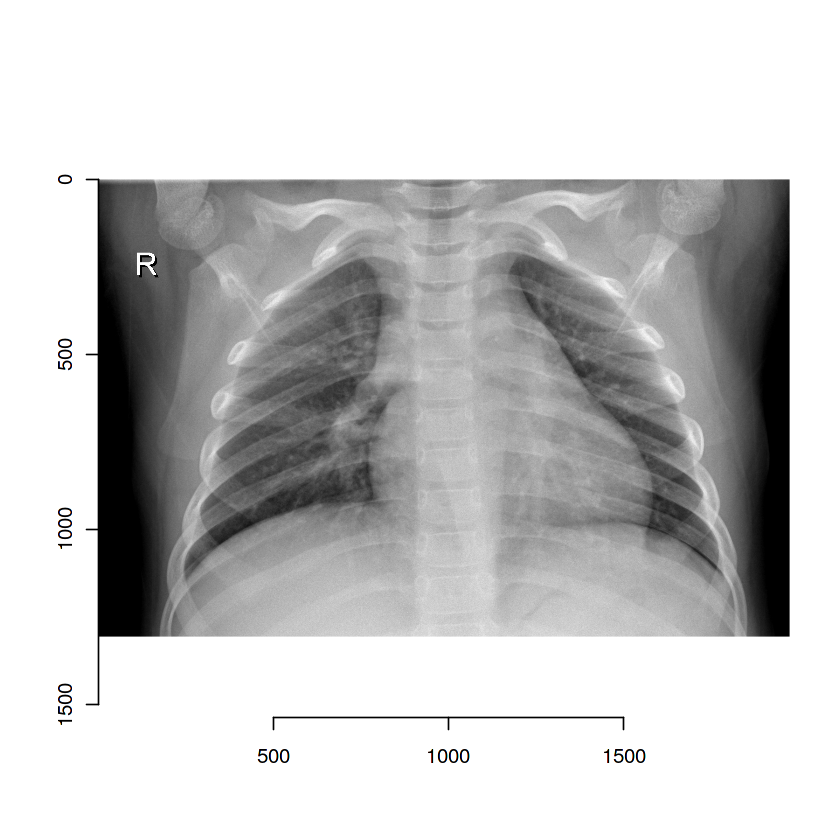

In [113]:
plot(benchmark_normal)

<div align="center"> Figure 6: Correctly predicted Normal x-ray </div>

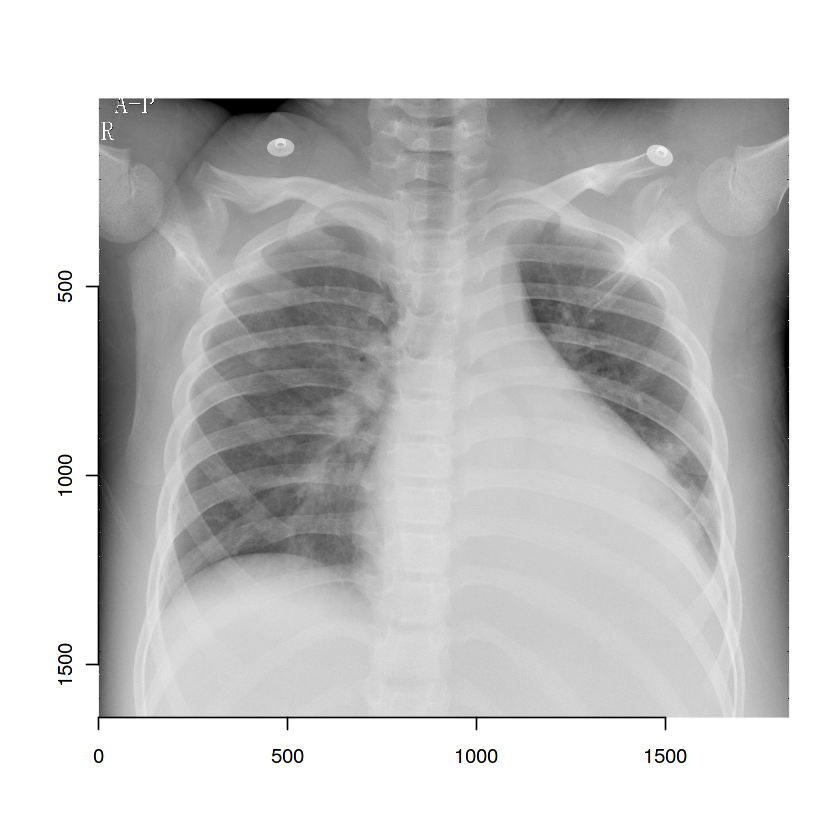

In [108]:
plot(benchmark_pneumonia)

<div align="center"> Figure 7: Correctly predicted Pneumonia x-ray </div>

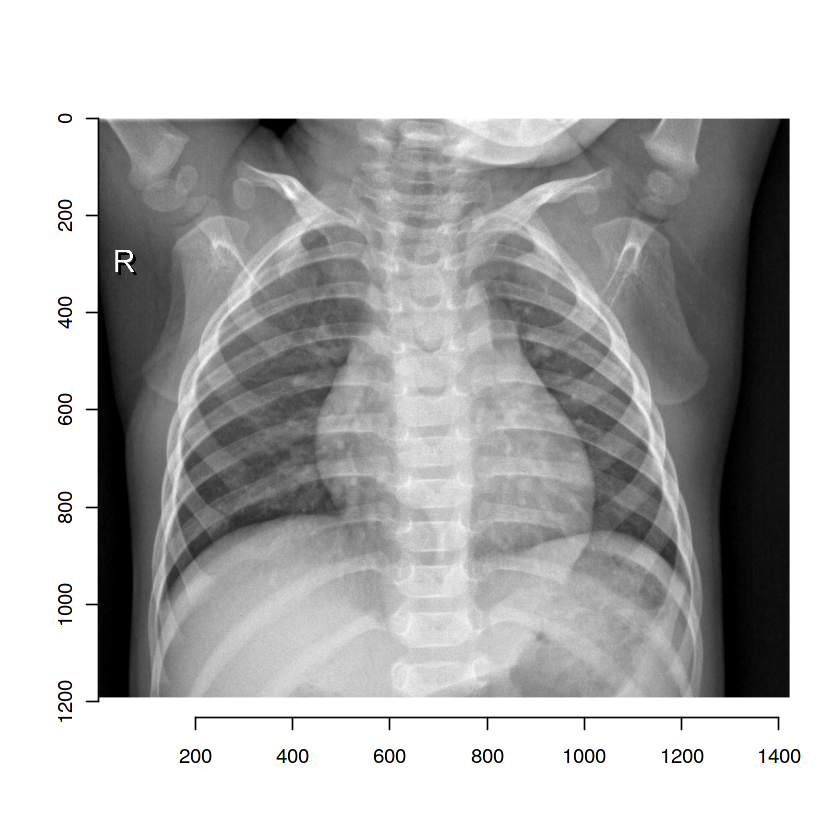

In [109]:
plot(compare_wrong_image)

<div align="center"> Figure 8: Incorrectly predicted as Pneumonia, actually is NORMAL x-ray </div>

From these images, we can see that the NORMAL heart is way smaller than a heart with PNEUMONIA. However, if we compare the picture where our model predicted wrongly with the normal benchmark picture, the left side of the heart is definitely bigger than a NORMAL sized heart although the right side is similarly sized, which is possibly why it thought that it belonged in the PNEUMONIA class.However, at the same time, if we compare this wrongly predicted one with a pneumonia benchmark picture, the right side of the heart is clearly smaller than the PNEUMONIA sized heart, hence causing the confusion.  We're quite sure that a doctor would've had trouble in predicting this as well as the size of the heart is between the lines of a NORMAL sized and a PNEUMONIA sized heart.


## 5 Discussion
-  Summary of Results 
    
Overall, we were satisfied and quite suprised that our simple knn-classification mode was able to achieve an accuracy model of 91.56%, thus were able to detect accurately paediatric pneumonia.

As for the wrong classification, we were able to determine that the error the model made was justified because of the situation that was given and we also made an inference that the magnitude of pixelation can influence the classfication model. This may be a result of our attempts to resize the image in order to reduce processing time.Had the model worked with a more higher quality image, it might've picked up on the size difference better and make even more accurate predictions.

Our model does have its shortcomings in that up-sampling data in the training set brought an unusual behavior in the accuracy plot (accuracy vs k values). We hypothesize it is due to the evaluation of accuracy in the cross validation process. This was the cause of overfitting which led to a very small value of k (k=1) showing up with the highest value of accuracy.

Computationally the image linearization process took the longest time (8 mins) but was not a big setback in our classification process. In the future, it is possible to focus our image processing on a cropped part of the model (part that encompasses the whole boundary of the lungs), as we may be wasting valuable computation time by processing the whole x-ray image. 

- Impact of Results 

Computer aided diagnosis a huge leap in the medical industry as well as any field requiring the techniques of image identification. Our classification model can be tested on other pulmonary based diseases such as chronic bronchitis, bronchiectasis, congestive heart failure and more. 

KNN classification is very advantageous in that it is resilient to noisy and effective data training when the training data is large, which is very common in the biomedical field as there is huge amount of data and samples available. However, the value of the parameter K (number of nearest neighbors) has to be determined to execute the KNN classifier. Furthermore, on an image classification aspect, no specific variables could be added on top of the linearized images such as history of health diseases and gene inheritance disorders.that could make the classification more accurate.
 

- Further Projects based on Results

Since we only processed a subset of the data due to server and computational power limitations, our next step would hopefully aim towards increase our computational efficiency either through a hardware upgrade or through BigQuery to process larger datasets. 

We have been looking at diving into deep learning on image processing as there have been major advancement in image classification using Convolutional Neautral Networks (CNN) with tools such as Keras and Tensorflow. It would be interesting to compare the accuracy of other types of classification with that of knn classification and adopt methodologies based on what works best. 

## 6 References
Rudan I. Boschi-Pinto C. Biloglav Z. Mulholland K. Campbell H. Epidemiology and etiology of childhood pneumonia. Bull. World Health Organ. 2008; 86: 408-416

Rajpurkar P, Irvin J, Zhu K, Yang B, Mehta H, Duan T, et al. CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning; 2017 [cited 1 July 2018]. Preprint. Available from: https://arxiv.org/abs/1711.05225.